Jupyter Notebook to Apply XGBoost and Compute Performance of Classification, utilizes bundlenet.py library (among others)

In [1]:
from glob import glob
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import bundlenet as bn
from dipy.io.streamline import load_trk, save_trk
from sklearn.metrics import precision_recall_fscore_support as score

Using TensorFlow backend.


Load in probabilities for subjects to train XGBoost

In [2]:
subj='970764'
loaded_from_file = np.load('model_p/p_subj'+ subj + '_nclass16_do0_nc3_fc1.npz')
labels_concat = loaded_from_file['labels']
p_concat = loaded_from_file['p']
for subj in '972566','973770','978578','979984','983773':
    loaded_from_file = np.load('model_p/p_subj'+ subj + '_nclass16_do0_nc3_fc1.npz')
    labels_subj = loaded_from_file['labels']
    p_subj = loaded_from_file['p']
    labels_concat = np.concatenate((labels_concat,labels_subj))
    p_concat = np.concatenate((p_concat,p_subj))

Load in test subject 

In [3]:
subj='100307'
loaded_from_file = np.load('model_p/p_subj'+ subj + '_nclass16_do0_nc3_fc1.npz')
labels_test = loaded_from_file['labels']
p_test = loaded_from_file['p']
p_bund_test = np.argmax(p_test,axis=1)
prob_bund_test = np.max(p_test,axis=1)

Convert values to two classes (0/1) and run XGBoost (to learn which streamlines to thow away)

In [4]:
labels_concat_2class = labels_concat.copy()
labels_concat_2class[labels_concat_2class<16] = 0
labels_concat_2class[labels_concat_2class==16] = 1
labels_test_2class = labels_test.copy()
labels_test_2class[labels_test_2class<16] = 0
labels_test_2class[labels_test_2class==16] = 1
p_2class = bn.run_xgboost(p_concat,labels_concat_2class,p_test,labels_test_2class,10,2,0.5)

Calculate precision and recall for XGBoost

In [5]:
precision, recall, fscore, support = score(labels_test_2class,p_2class)

In [6]:
precision

array([0.80529242, 0.97070488])

In [7]:
recall

array([0.81772558, 0.96830213])

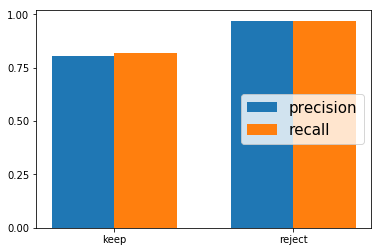

In [8]:
ind = np.arange(2) 
width = 0.35       
plt.bar(ind, precision, width, label='precision')
plt.bar(ind + width, recall, width,
    label='recall')
plt.xticks(ind + width / 2, ('keep', 'reject'))
plt.legend(loc='right',fontsize='15')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.savefig('precisionrecallbar_allsl.jpg')

Filter out the rejected streamlines

In [9]:
keep = p_2class==0
labels = labels_test[keep]
p_idx = np.argmax(p_test,axis=-1)
p = p_idx[keep]

In [10]:
bundle_files = sorted(glob('/home/ubuntu/Atlas_in_MNI_Space_16_bundles/bundles/*.trk'))
bundle_names = []
for fname in bundle_files:
    bundle_names.append(fname.split('/')[-1].split('bundles_')[-1].split('.trk')[0])
    

In [11]:
bundle_names

['AF_L',
 'AF_R',
 'CCMid',
 'CC_ForcepsMajor',
 'CC_ForcepsMinor',
 'CST_L',
 'CST_R',
 'C_L',
 'C_R',
 'F_L',
 'F_R',
 'IF0F_R',
 'IFOF_L',
 'MCP',
 'UF_L',
 'UF_R']

Calculate precision and recall for bundle classification without and with XGBoost step

In [12]:
precision, recall, fscore, support = score(labels_test,p_idx)
precision = precision[0:16]
recall = recall[0:16]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


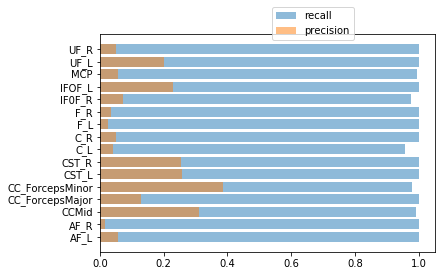

In [13]:
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 
plt.barh(np.arange(len(recall)), recall, align='center', alpha=0.5,label='recall')
plt.barh(np.arange(len(precision)), precision, align='center', alpha=0.5,label='precision')
plt.yticks(np.arange(len(precision)), bundle_names)
plt.legend(loc='center left', bbox_to_anchor=(0.5, 1.05))
plt.savefig('precisionrecallbar_noxgboost.pdf')

In [14]:
precision, recall, fscore, support = score(labels,p)
precision = precision[0:16]
recall = recall[0:16]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


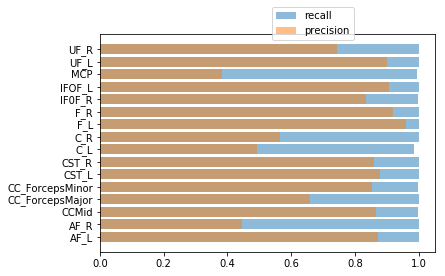

In [15]:
plt.barh(np.arange(len(recall)), recall, align='center', alpha=0.5,label='recall')
plt.barh(np.arange(len(precision)), precision, align='center', alpha=0.5,label='precision')
plt.yticks(np.arange(len(precision)), bundle_names)
plt.legend(loc='center left', bbox_to_anchor=(0.5, 1.05)) 
plt.savefig('precisionrecallbar.pdf')

In [16]:
np.mean(precision)

0.7586414689069232

Save out .trk files for visual check

In [17]:
streamlines_all_nomni = bn.read_sl('/home/ubuntu/recobundles/100307/out_work/whole_brain_MNI_tracks_from_sh__moved.trk')

In [35]:
sl_num=0
a = np.where(p_2class==0)[0]
b = np.where((p_bund_test==sl_num) & (prob_bund_test >0.9))[0]
sl_bn = np.intersect1d(a,b)

In [36]:
sl_reco = np.where(labels_test==sl_num)

In [37]:
sl_both = np.intersect1d(sl_bn, sl_reco)
sl_justbn = np.setdiff1d(sl_bn, sl_reco)
sl_justreco = np.setdiff1d(sl_reco, sl_bn)

In [38]:
save_trk('slboth'+bundle_names[sl_num]+'.trk', streamlines=streamlines_all_nomni[sl_both], affine=np.eye(4))
save_trk('slbn'+bundle_names[sl_num]+'.trk', streamlines=streamlines_all_nomni[sl_justbn], affine=np.eye(4))
save_trk('slreco'+bundle_names[sl_num]+'.trk', streamlines=streamlines_all_nomni[sl_justreco], affine=np.eye(4))

In [22]:
save_trk('slunlabeled.trk', streamlines=streamlines_all_nomni[labels_test_2class==1], affine=np.eye(4))

In [23]:
sl_bn = np.where((p_bund_test==sl_num) & (prob_bund_test >0.9))[0]
save_trk('slbn'+bundle_names[sl_num]+'_noxg.trk', streamlines=streamlines_all_nomni[sl_bn], affine=np.eye(4))

In [24]:
for i, bund in enumerate(bundle_names):
    print(bund)
    bn.savesegtrk(streamlines_all_nomni, p_2class, p_bund_test, i, prob_bund_test, 0.9,'TRK/'+bund+'.trk',0)

AF_L
AF_R
CCMid
CC_ForcepsMajor
CC_ForcepsMinor
CST_L
CST_R
C_L
C_R
F_L
F_R
IF0F_R
IFOF_L
MCP
UF_L
UF_R
